In [1]:
import pandas as pd
import numpy as np
from textatistic import Textatistic

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

# import the nlp packages and load the english language module
import spacy
import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import en_core_web_sm
nlp = en_core_web_sm.load()

# import the package for sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# ML packages
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df_nlp.csv', index_col = 0)

In [3]:
df.shape

(21312, 24)

In [4]:
df = df.reset_index()

### Readability analysis
The readability assesses how complex an English passage to its readers. A mathematical formula taking usage of vocabulary (number of characters and syllabus) and sentence length into consideration. The readability scale ranges from primary school up to college graduate level.

The tool in this project for readability analysis is textatistic. Documentation can be found <a href='https://pypi.org/project/textatistic/'>here</a>.

Remind: Column `text_clean` is the tweets without urls and extra whitespace and special characters.

__The Score__
The Textatistic returns several readability scores and each score is based on a different assessment scale. This project only looks at Flesh reading score which was developed by J. Peter Kincaid in 1957. The explanation of the scoring system and interpretation can be found <a href='https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests'>here</a>.

In [5]:
biden = str(df[df.last_name == 'Biden']['text_clean'])
warren = str(df[df.last_name == 'Warren']['text_clean'])
sanders = str(df[df.last_name == 'Sanders']['text_clean'])
yang = str(df[df.last_name == 'Yang']['text_clean'])
buttigieg = str(df[df.last_name == 'Buttigieg']['text_clean'])

doc_list = [biden, warren, sanders, yang, buttigieg]

In [6]:
scores = []
for doc in doc_list:
    readability = Textatistic(doc).scores
    scores.append(readability['flesch_score'])
    
read_df = pd.DataFrame(scores, index=['Biden', 'Warren', 'Sanders', 'Yang', 'Buttigieg'], 
             columns=['scores'])
read_df = read_df.sort_values(by=['scores'])

Text(0.5, 1.0, 'The lower the score the more difficult to read.')

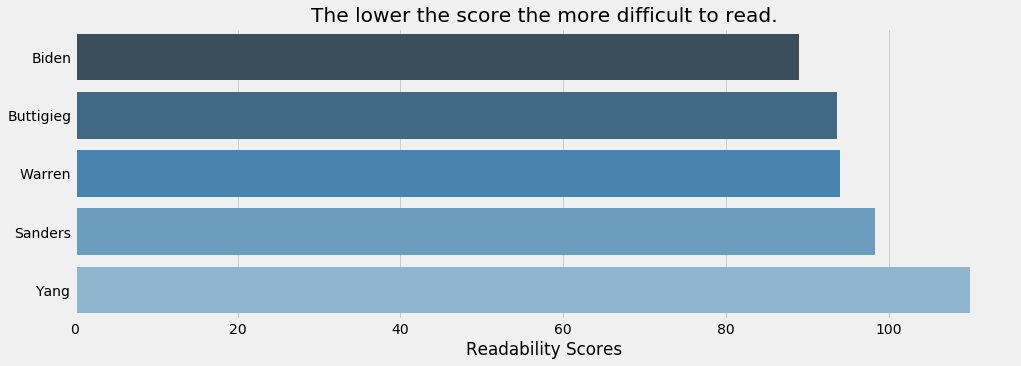

In [7]:
plt.figure(figsize=(15, 5))
sns.barplot(x = 'scores', y = read_df.index, data=read_df, palette="Blues_d")
plt.xlabel('Readability Scores')
plt.title('The lower the score the more difficult to read.')

### Sentiment analysis
<a href='https://github.com/cjhutto/vaderSentiment'>VADER (Valence Aware Dictionary and sEntiment Reasoner)</a> is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media. 

<a href='http://datameetsmedia.com/vader-sentiment-analysis-explained/'>VADER Sentiment Analysis Explained</a>

In [8]:
# Initiate the model
analyzer = SentimentIntensityAnalyzer()

__The Scoring__

VADER will return a dictionary of 4 scores for any text you pass it; Positive, Neutral, Negative, and Compound scores, all ranging from -1 to 1. We’ll be mostly interested in the compound scores for tracking the overall sentiment of a tweet.

The compound score is computed by summing the valence scores of each word in the lexicon, adjusted according to the rules, and then normalized to be between -1 (most extreme negative) and +1 (most extreme positive). This is the most useful metric if you want a single unidimensional measure of sentiment for a given sentence. Calling it a 'normalized, weighted composite score' is accurate.

It is also useful for researchers who would like to set standardized thresholds for classifying sentences as either positive, neutral, or negative. Typical threshold values (used in the literature cited on this page) are:

* positive sentiment: compound score >= 0.05
* neutral sentiment: (compound score > -0.05) and (compound score < 0.05)
* negative sentiment: compound score <= -0.05

In [9]:
# There are 68 null cells in the column that the sentiment analysis is based on.
# So it is necessary to fill the null values 
print(df['text'].isna().sum())
df['text'] = df['text'].fillna(' ')

68


In [10]:
# The sentiment analysis returns a dictionary containing 4 scores
# Scores: negative, positive, neutural and compound
# Compound score is the type this project uses to determine a tweet's sentiment
df['compound'] = df['text'].apply(lambda x:analyzer.polarity_scores(x)['compound'])

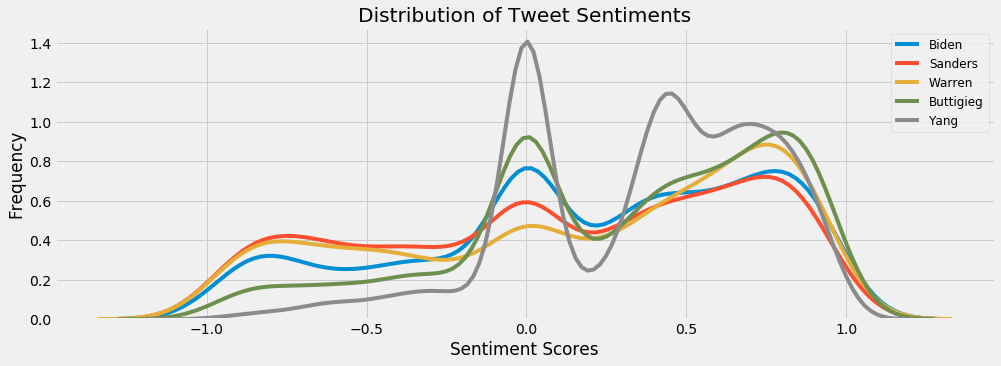

In [11]:
plt.figure(figsize=(15, 5))

df_hist = df[df.author == 'JoeBiden']
sns.distplot(df_hist['compound'], hist = False, kde = True, label='Biden')

df_hist = df[df.author == 'BernieSanders']
sns.distplot(df_hist['compound'], hist = False, kde = True, label='Sanders')

df_hist = df[df.author == 'ewarren']
sns.distplot(df_hist['compound'], hist = False, kde = True, label='Warren')

df_hist = df[df.last_name == 'Buttigieg']
sns.distplot(df_hist['compound'], hist = False, kde = True, label='Buttigieg')

df_hist = df[df.author == 'AndrewYang']
sns.distplot(df_hist['compound'], hist = False, kde = True, label='Yang')

plt.xlabel('Sentiment Scores')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet Sentiments')
plt.legend(prop={'size': 12})
plt.show()

In [12]:
# The compound score is a numeric column
# Use the threshholds to convert it to categorical
df['sentiment'] = pd.cut(df['compound'], bins = [-1, -0.05, 0.05, 1], 
       labels=['negative', 'neutural', 'positive'])

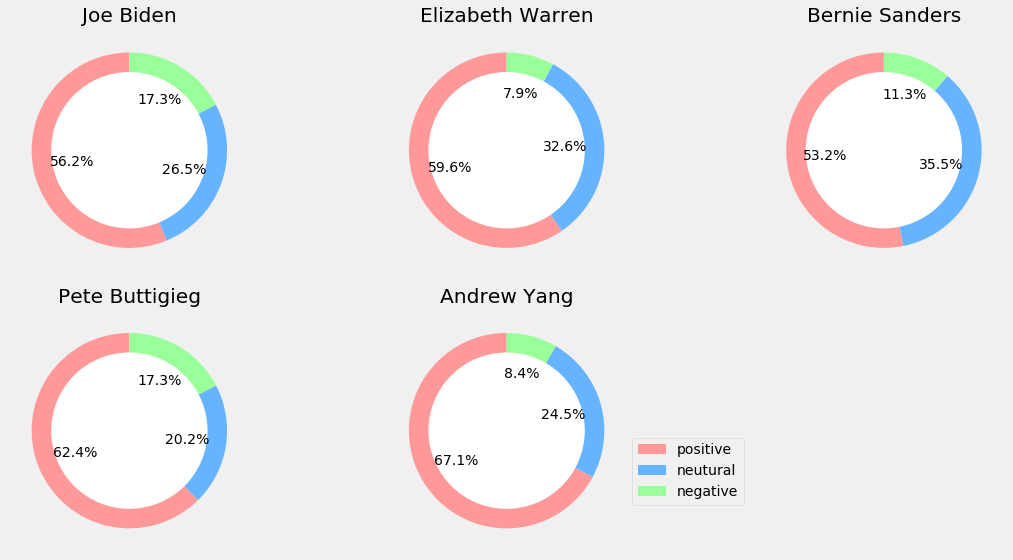

In [13]:
plt.figure(figsize=(15,8))
# the 1st donut chart
plt.subplot(2,3,1)
pie1 = plt.pie(list(df[df.last_name =='Biden']['sentiment'].value_counts(normalize=True).values),
        colors = ['#ff9999','#66b3ff','#99ff99'], 
        autopct='%1.1f%%', startangle=90)
# draw a white circle at the center of the pie
centre_circle = plt.Circle((0,0),0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Joe Biden')

# the 2nd donut chart
plt.subplot(2,3,2)
pie2 = plt.pie(list(df[df.last_name =='Warren']['sentiment'].value_counts(normalize=True).values),
        colors = ['#ff9999','#66b3ff','#99ff99'], 
        autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Elizabeth Warren')

# the 3rd donut chart
plt.subplot(2,3,3)
pie3 = plt.pie(list(df[df.last_name =='Sanders']['sentiment'].value_counts(normalize=True).values),
        colors = ['#ff9999','#66b3ff','#99ff99'], 
        autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Bernie Sanders')

# the 4th donut chart
plt.subplot(2,3,4)
pie4 = plt.pie(list(df[df.last_name =='Buttigieg']['sentiment'].value_counts(normalize=True).values),
        colors = ['#ff9999','#66b3ff','#99ff99'],  
        autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Pete Buttigieg')

# the 5th donut chart
plt.subplot(2,3,5)
pie5 = plt.pie(list(df[df.last_name =='Yang']['sentiment'].value_counts(normalize=True).values),
        colors = ['#ff9999','#66b3ff','#99ff99'], 
        autopct='%1.1f%%', startangle=90)
centre_circle = plt.Circle((0,0),0.80,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Andrew Yang')

plt.legend([pie1, pie2, pie3, pie4],
          labels = df[df.last_name =='Yang']['sentiment'].value_counts(normalize=True).index,
          loc = 'best',
          bbox_to_anchor=(1.5, 0.5))
plt.tight_layout()

### Tweet classifier
#### Preprocessing
This step is to further clean the tweet text: remove the stop words, return word to its root and delete non-alphabetical words. This process also tokenize each tweet and convert it to a format that can be understood by machine learning algorithms.

In [14]:
# The model training will be based on 'text_clean' column
# This column already had url and special characters removed
# The first step is to fill in all null values.
df['text_clean'] = df['text_clean'].fillna(' ')

In [15]:
# A function to tokenize and preprocess each tweet
def spacy_tokenizer(x):
    tokens = nlp(x)
    word_list = [token.lemma_ for token in tokens if token.lemma_ != '-PRON-' 
                 and token.is_stop != True]
    word_list = [word.lower() for word in word_list if word.isalpha() 
                 and len(word)>3]
    return word_list

In [16]:
df['text_nlp'] = df['text_clean'].apply(spacy_tokenizer)

In [17]:
# check the end result of preprocessing function
all_tokens = []
for x in df['text_nlp']:
    for word in x:
        all_tokens.append(word)
        
tokens = pd.DataFrame(all_tokens, columns = ['token'])
tokens['token'].value_counts().head()

people       2445
thank        2178
fight        2030
president    1975
need         1872
Name: token, dtype: int64

#### Train a Machine Learning Classifier
This project is a typical multi-class text classification problem. Given a new tweet comes in, the classifier assigns it to one of 5 categories. This section is going to find the best model for the classifier.

This text classifier is based on <a href = 'https://jakevdp.github.io/PythonDataScienceHandbook/05.05-naive-bayes.html'>naive bayes model</a>, which is a group of fast and simple classification algorithms that are often suitable for very high-dimensional datasets. Because they are so fast and have so few tunable parameters, they end up being very useful as a quick-and-dirty baseline for a classification problem. 

In Bayesian classification, we're interested in finding the probability of a label given some observed features (detecting author of a tweet based on its content in this case). Text classification is a typical example that the features are related to word counts or frequencies within the documents to be classified, and this is the place that multinomial naive Bayes model is handy. 

In [18]:
X = df['text_clean']
y = df['last_name']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.4)

##### Training the model with bage of words

In [19]:
estimators_bag = [('bagofwords', CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1, 3))),
              ('classifier', MultinomialNB())]


pipe_bag = Pipeline(estimators_bag)

params_bag = {'bagofwords__min_df': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 70, 80, 90, 100]}
 
grid_bag = GridSearchCV(pipe_bag, params_bag, cv=5)

fittedgrid_bag = grid_bag.fit(X_train, y_train)

In [20]:
fittedgrid_bag.best_estimator_

Pipeline(memory=None,
         steps=[('bagofwords',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=2,
                                 ngram_range=(1, 3), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x11b6d0598>,
                                 vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=False)

In [21]:
fittedgrid_bag.cv_results_['mean_test_score']

array([0.71095644, 0.70274498, 0.69672323, 0.69124892, 0.68835536,
       0.68428873, 0.6801439 , 0.67678111, 0.6749042 , 0.6554313 ,
       0.6413545 , 0.62946743, 0.62047392, 0.60365997, 0.59161649,
       0.58457809, 0.57785251])

##### Training the model with TF-IDF

In [22]:
estimators_tf = [('tf-idf', TfidfVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1, 3), stop_words='english')),
              ('classifier', MultinomialNB())]


pipe_tf = Pipeline(estimators_tf)

params_tf = {'tf-idf__min_df': [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 70, 80, 90, 100]}
 
grid_tf = GridSearchCV(pipe_tf, params_tf, cv=5)

fittedgrid_tf = grid_tf.fit(X_train, y_train)

In [23]:
fittedgrid_tf.best_estimator_

Pipeline(memory=None,
         steps=[('tf-idf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=2, ngram_range=(1, 3), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=<function spacy_tokenizer at 0x11b6d0598>,
                                 use_idf=True, vocabulary=None)),
                ('classifier',
                 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))],
         verbose=F

In [24]:
fittedgrid_tf.cv_results_['mean_test_score']

array([0.69351685, 0.69312583, 0.69203097, 0.68710409, 0.68272464,
       0.68061312, 0.67654649, 0.67420036, 0.67169782, 0.6519903 ,
       0.64018143, 0.62524439, 0.61648549, 0.59802925, 0.59028701,
       0.58332682, 0.57511535])

##### Select the model

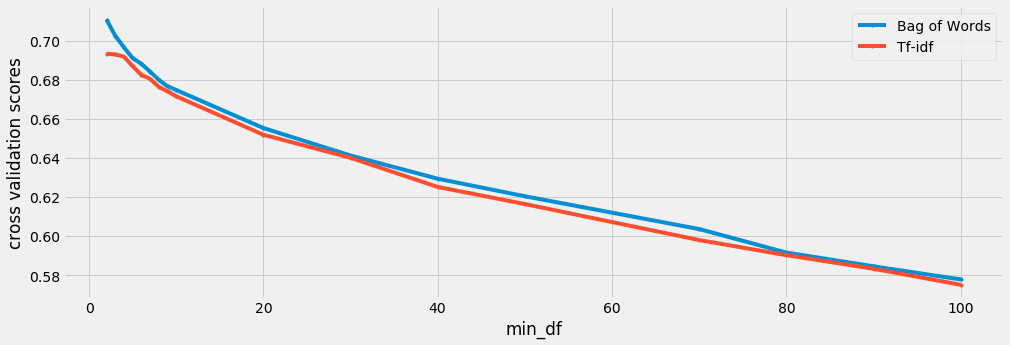

In [25]:
# Plot cross validation results from two models
min_df = [2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 70, 80, 90, 100]

plt.figure(figsize = (15, 5))
plt.plot(min_df, fittedgrid_bag.cv_results_['mean_test_score'], marker = '.', label = 'Bag of Words')
plt.plot(min_df, fittedgrid_tf.cv_results_['mean_test_score'], marker = '.', label = 'Tf-idf')
plt.legend()

plt.xlabel('min_df')
plt.ylabel('cross validation scores')
plt.show()

As the plot indicates, the performances from models — using bag of words and tf-idf respectively — are close. The best score (71%) is from the bag-of-words model when the tokenizer setting min_df at 2. I will use this model and setting for the text classifier. 

In [26]:
vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,3), stop_words = 'english', 
                           min_df = 2)

X_train_vector = vector.fit_transform(X_train)
X_test_vector = vector.transform(X_test)

In [27]:
model = MultinomialNB().fit(X_train_vector, y_train)
y_predict = model.predict(X_test_vector)

#### Model Evaluation

In [28]:
mat = pd.DataFrame(confusion_matrix(y_test, y_predict))
mat = mat * 100.0/mat.sum()

Text(0.5, 1, 'Confussion Matrix with precision rates')

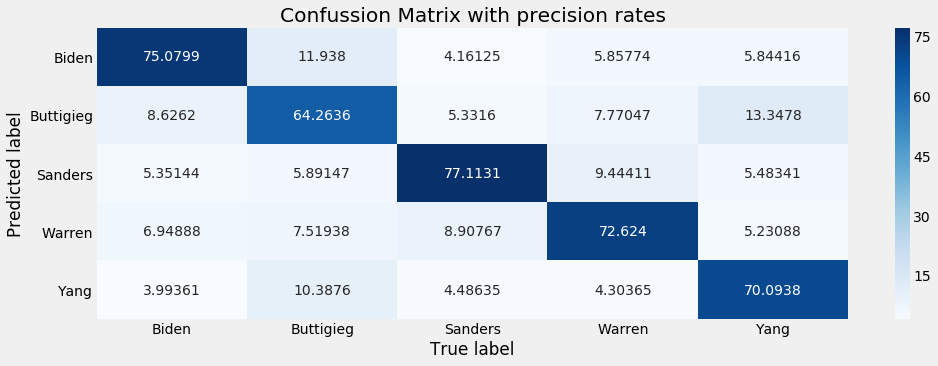

In [29]:
plt.figure(figsize = (15, 5))
sns.heatmap(mat, annot=True, cmap = 'Blues', fmt = 'g',
           xticklabels = np.unique(y_predict),
           yticklabels = np.unique(y_predict))

plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title('Confussion Matrix with precision rates')

In [30]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       Biden       0.75      0.66      0.70      1418
   Buttigieg       0.64      0.55      0.59      1519
     Sanders       0.77      0.72      0.75      1639
      Warren       0.73      0.72      0.72      1681
        Yang       0.70      0.86      0.77      2268

    accuracy                           0.72      8525
   macro avg       0.72      0.70      0.71      8525
weighted avg       0.72      0.72      0.71      8525



Precision and recall are two metrics measure the performance of a classification model. Precision measures what proportion of a model assigned to positive are actually members of the positive class. Recall measures how many members of the positive class the model correctly identified out of the total.

This model has the highest precision score on Biden's tweets and highest recall score on Andrew Yang's tweets. The two scores can be interpreted as follows:

* precision on Biden = Biden tweets correctly identified /(Biden tweets correctly identified + other candidates'tweets identified as Biden's)

* recall on Yang = Yang tweets correctly identified / (Yang tweets correctly identified + Yang tweets not identified as Yang's)